In [5]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import copy
from tqdm import tqdm

# from metrics import evaluation_metrics

from slim import SLIMDataModule
import torch.nn as nn

# Instantiate the DataModule

In [25]:
import matplotlib.pyplot as plt

data_module = SLIMDataModule(data_dir="./data", batch_size=1)
train_dataloader = data_module.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))

Time taken to load ./data/hr_train.csv: 4.84249210357666 seconds
Time taken to load ./data/lr_train.csv: 0.6156792640686035 seconds
Converting vectors to matrices
Converting vectors to matrices


In [26]:
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


def batch_normalize(batch):
    batch_n = torch.zeros_like(batch)
    for i, A in enumerate(batch):
        batch_n[i] = symmetric_normalize(A + torch.eye(n=A.shape[0]))
    return batch_n

In [90]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    train_node_features=None,
    val_node_features=None,
    num_epochs=100,
    lr=0.01,
    validate_every=1,
    patience=10,
    criterion=None,
    intermediate_losses=False,
    skip=False,
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    train_dataloader : torch.utils.data.DataLoader
        DataLoader for the training set.
    val_dataloader : torch.utils.data.DataLoader
        DataLoader for the validation set.
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    validate_every : int
        Validate (and possibly checkpoint) every 'validate_every' epochs.
    patience : int
        Patience for learning rate scheduler.
    criterion : torch.nn.Module
        Loss function.

    Returns:
    --------
    best_loss_history : list
        The training loss history across epochs.
    best_model_state_dict : dict
        The state dictionary of the model achieving the best validation accuracy.
    """

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience
    )
    train_loss_history = []
    val_loss_history = []

    best_val_loss = torch.inf
    best_model_state_dict = None
    val_loss = 0.0

    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        progress_bar.set_description(f"Epoch {epoch}|{num_epochs}")
        model.train()
        epoch_loss = 0.0

        for i, batch in enumerate(train_dataloader):
            inputs, targets = batch
            # inputs = batch_normalize(inputs)
            inputs = inputs.squeeze(0)
            targets = targets.squeeze(0)
            optimizer.zero_grad()

            X = train_node_features[i] if train_node_features is not None else None

            # Forward pass on training data
            outputs, A_hist, A_recon_hist = model.forward(A=inputs, X=X, skip=skip)
            loss = criterion(
                outputs,
                targets.to(model.device),
                A_hist,
                A_recon_hist,
                intermediate_losses=intermediate_losses,
            )
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Record training loss
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)
        train_loss_history.append(avg_loss)

        # Validation step
        if (epoch + 1) % validate_every == 0 or (epoch + 1) == num_epochs:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for i, batch in enumerate(val_dataloader):
                    inputs, targets = batch
                    inputs = inputs.squeeze(0)
                    targets = targets.squeeze(0)
                    X = val_node_features[i] if val_node_features is not None else None
                    outputs, A_hist, A_recon_hist = model(A=inputs, X=X, skip=skip)

                    val_loss += criterion(
                        outputs,
                        targets.to(model.device),
                        A_hist,
                        A_recon_hist,
                        intermediate_losses,
                    ).item()

            val_loss /= len(val_dataloader)
            val_loss_history.append(val_loss)
            scheduler.step(val_loss)

            lr = get_lr(optimizer)

            # Check if this is the best f1 score so far
            if val_loss > best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = copy.deepcopy(model.state_dict())

            if lr < 1e-5:
                break

        progress_bar.set_postfix({"train_loss": avg_loss, "val_loss": val_loss})

    # If we have a best model, load it
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return train_loss_history, val_loss_history, best_model_state_dict


@torch.no_grad()
def evaluate_model(model, dataloader):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    from metrics import evaluation_metrics

    model.eval()

    preds = []
    true = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.squeeze(0)
        targets = targets.squeeze(0)
        inputs.to(model.device)
        outputs, _, _ = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(targets.detach().cpu().numpy())

    batch_metrics = evaluation_metrics(preds, true)

    return batch_metrics

In [ ]:
# putting it all together - code taken from https://github.com/HongyangGao/Graph-U-Nets/tree/master

import torch
from torch import Tensor
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.nn as nn
import numpy as np
import networkx as nx


def reconstruct_adjacency(X, threshold=0.2):
    """
    Reconstruct adjacency from node embeddings while preserving fMRI-like structure.

    Args:
        X (torch.Tensor): Node embeddings of shape [num_nodes, hidden_dim]
        threshold (float): Value below which edges are removed for sparsity

    Returns:
        adj (torch.Tensor): Reconstructed weighted adjacency matrix
    """
    X_norm = X
    # Compute cosine similarity matrix
    adj = F.relu(X_norm @ X_norm.T)  # Values in range [-1, 1]

    # adj = torch.sigmoid(adj)

    # Apply sparsification: Keep only values above threshold
    # adj = torch.where(adj > threshold, adj, torch.zeros_like(adj))

    return adj


class GraphUpsampler(nn.Module):
    def __init__(
        self,
        in_dim,
        hidden_dim,
        n_nodes,
        m_nodes,
        act,
        drop_p,
        num_iterations=1,
    ):
        """
        Args:
        - in_dim: Input node feature dimension
        - hidden_dim: Hidden dimension for message passing
        - num_iterations: Number of iterative updates
        - upsample_factor: Factor by which to increase node count
        """
        super(GraphUpsampler, self).__init__()
        self.num_iterations = num_iterations
        self.n_nodes = n_nodes
        self.m_nodes = m_nodes

        # Message passing layers
        self.conv1 = GCN(in_dim, hidden_dim, act, drop_p)
        self.conv2 = GCN(hidden_dim, hidden_dim, act, drop_p)

        # MLP for new node generation
        self.upsample_mlp = nn.Linear(n_nodes, m_nodes)

    def forward(self, X, A, refine=True):
        """
        Args:
        - x: Node features [num_nodes, in_dim]
        - adj_matrix: Initial adjacency matrix [num_nodes, num_nodes]

        Returns:
        - Upsampled adjacency matrix [self.m_nodes, self.m_nodes]
        - Upsampled node features [new_num_nodes, in_dim]
        """

        # Generate new nodes by transforming existing ones
        X_upsampled = torch.sigmoid(self.upsample_mlp(X.T).T)  # [num_nodes, in_dim]
        # Concatenate old and new nodes
        # X_upsampled = torch.cat([X, new_nodes], dim=0)

        A_upsampled = reconstruct_adjacency(X=X_upsampled)

        # print("Mean : ", A_upsampled.mean().item(), "Std :", A_upsampled.std().item())

        # Message passing to refine embeddings
        if refine:
            for _ in range(self.num_iterations):
                X_upsampled = self.conv1(A_upsampled, X_upsampled)
                X_upsampled = F.relu(X_upsampled)
                A_upsampled = reconstruct_adjacency(X_upsampled)

                X_upsampled = self.conv2(A_upsampled, X_upsampled)
                X_upsampled = F.relu(X_upsampled)

                # Reconstruct adjacency with updated embeddings
                A_upsampled = reconstruct_adjacency(A_upsampled)

        return A_upsampled


class GraphUnet(nn.Module):

    def __init__(self, ks, n_nodes, m_nodes, dim, act, drop_p):
        super(GraphUnet, self).__init__()
        self.ks = ks
        self.dim = dim

        self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.upsampler = GraphUpsampler(
            in_dim=dim,
            hidden_dim=dim,
            n_nodes=n_nodes,
            m_nodes=m_nodes,
            act=act,
            drop_p=drop_p,
        )
        self.l_n = len(ks)
        for k in ks:
            # out_dim = dim
            out_dim = int(dim / k)
            self.down_gcns.append(GCN(dim, out_dim, act, drop_p))
            self.up_gcns.append(GCN(out_dim, dim, act, drop_p))
            self.pools.append(Pool(k, out_dim, drop_p))
            self.unpools.append(Unpool(dim, dim, drop_p))
            dim = out_dim

        self.up_gcns = self.up_gcns[::-1]
        # self.node_features = nn.Parameter(torch.randn(n_nodes, dim))
        self.bottom_gcn = GCN(dim, dim, act, drop_p)

    @property
    def device(self):
        return next(self.parameters()).device

    def build_batch_features(
        self, batch: list[torch.Tensor], n_jobs: int = 1
    ) -> torch.Tensor:
        # Build batch features using topological information
        from joblib import Parallel, delayed

        # Use the build_node_features function to build features for each graph in the batch
        features = Parallel(n_jobs=n_jobs)(
            delayed(self.build_node_features)(adjacency) for adjacency in batch
        )
        return torch.stack(features, dim=0)

    def build_node_features(self, adjacency: torch.Tensor) -> torch.Tensor:
        # Build node features using topological information

        # Compute degree matrix
        D = torch.diag(torch.sum(adjacency, dim=1)).cpu()

        # Compute Node betweenness centrality
        G = nx.from_numpy_array(adjacency.cpu().numpy())
        betweenness = torch.tensor(
            list(nx.betweenness_centrality(G).values()), dtype=torch.float32
        )

        # Compute Node closeness centrality
        closeness = torch.tensor(
            list(nx.closeness_centrality(G).values()), dtype=torch.float32
        )

        # Compute Node clustering coefficient
        clustering = torch.tensor(list(nx.clustering(G).values()), dtype=torch.float32)

        # Compute eigenvector centrality
        eigenvector = torch.tensor(
            list(nx.eigenvector_centrality(G).values()), dtype=torch.float32
        )

        # Compute Laplacian eigenvecs
        eigvals, eigvecs = torch.linalg.eigh(D - adjacency.cpu())
        laplacian_eigenvecs = eigvecs[:, 1 : self.dim - 3]

        # Concatenate all features
        node_features = torch.stack(
            [betweenness, closeness, clustering, eigenvector], dim=1
        )
        # Include Laplacian eigenvecs
        node_features = torch.cat([node_features, laplacian_eigenvecs], dim=1)

        return node_features

    def forward(
        self, A: torch.Tensor, skip: bool = False, threshold: float = -1, X=None
    ):
        # Process A
        if threshold > 0:
            A = torch.where(A > threshold, A, torch.zeros_like(A))
        A = A + torch.eye(A.shape[0])
        A = symmetric_normalize(A)
        A = A.to(self.device)

        if X is None:
            X = torch.randn(A.shape[0], self.dim, device=self.device)
        else:
            X = X.to(self.device)

        A_history = []
        A_recon_history = []
        indices_list = []
        down_outs = []
        org_A = A.clone()
        if skip:
            org_X = X.clone()
        for i in range(self.l_n):
            X = self.down_gcns[i](A, X)
            A_history.append(A)
            down_outs.append(X)
            A, X, idx = self.pools[i](A, X)
            indices_list.append(idx)

        X = self.bottom_gcn(A, X)
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1
            A, idx = A_history[up_idx], indices_list[up_idx]
            A, X = self.unpools[i](A, X, down_outs[up_idx], idx)
            X = self.up_gcns[i](A, X)

            A_recon = reconstruct_adjacency(X)
            A_recon_history.append(A_recon)
            if skip:

                X = X.add(down_outs[up_idx])

        if skip:
            X = X.add(org_X)

        A_upsampled = self.upsampler.forward(X, org_A)

        return A_upsampled, A_history, A_recon_history


class GCN(nn.Module):

    def __init__(self, in_dim, out_dim, act, p):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim, bias=False)
        self.act = act
        self.drop = nn.Dropout(p=p) if p > 0.0 else nn.Identity()

    def forward(self, A, X):
        X = self.drop(X)  # they have added dropout
        X = torch.matmul(A, X)
        X = self.proj(X)
        X = self.act(X)
        return X


class Pool(nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = nn.Sigmoid()
        self.proj = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()  # added dropout here

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, A, X, pre_h, idx):
        new_h = X.new_zeros([A.shape[0], X.shape[1]])
        new_h[idx] = X
        return A, new_h


def top_k_graph(scores, A, X, k):
    num_nodes = A.shape[0]
    values, idx = torch.topk(
        scores, max(2, int(k * num_nodes))
    )  # make sure k works based on number of current nodes
    X_pooled = X[idx, :]
    values = torch.unsqueeze(values, -1)
    X_pooled = torch.mul(X_pooled, values)
    A_treshold = torch.where(A > 0.10, torch.ones_like(A), torch.zeros_like(A))
    A_pooled = A_treshold.bool().float()
    A_pooled = (
        torch.matmul(A_pooled, A_pooled).bool().float()
    )  # second power to reduce chance of isolated nodes
    A_pooled = A[idx, :]
    A_pooled = A_pooled[:, idx]
    A_pooled = symmetric_normalize(A_pooled)
    return A_pooled, X_pooled, idx


def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv

In [136]:
def criterion(
    A_true, A_pred, A_hist=None, A_recon_hist=None, intermediate_losses: bool = False
):
    loss = F.mse_loss(A_true, A_pred)
    if intermediate_losses:
        i = 1
        for A, A_recon in zip(A_hist, A_recon_hist[::-1]):
            loss += F.mse_loss(A, A_recon)
            i += 1
    return loss

In [140]:
# Define the model, loss function, and optimizer

# Clear CUDA cache
torch.cuda.empty_cache()

# Define the model
in_dim = batch[0].shape[1]
out_dim = batch[1].shape[1]
dim = 15
model = GraphUnet(
    ks=[
        0.75,
        0.75,
        0.75,
    ],
    n_nodes=in_dim,
    m_nodes=out_dim,
    dim=dim,
    act=torch.relu,
    drop_p=0.1,
)
model.to(torch.device("cuda:2"))
# model.load_state_dict(torch.load("unet-26-02.pth"))

GraphUnet(
  (down_gcns): ModuleList(
    (0): GCN(
      (proj): Linear(in_features=15, out_features=20, bias=False)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): GCN(
      (proj): Linear(in_features=20, out_features=26, bias=False)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (2): GCN(
      (proj): Linear(in_features=26, out_features=34, bias=False)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
  (up_gcns): ModuleList(
    (0): GCN(
      (proj): Linear(in_features=34, out_features=26, bias=False)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): GCN(
      (proj): Linear(in_features=26, out_features=20, bias=False)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (2): GCN(
      (proj): Linear(in_features=20, out_features=15, bias=False)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
  (pools): ModuleList(
    (0): Pool(
      (sigmoid): Sigmoid()
      (proj): Linear(in_features=20, out_features=1, bias=True)
      (drop): Dropou

In [72]:
print("Computing train node features...")
train_node_features = [
    model.build_node_features(A[0].squeeze(0))
    for A in tqdm(data_module.train_dataloader())
]

print("Computing val node features...")
val_node_features = [
    model.build_node_features(A[0].squeeze(0))
    for A in tqdm(data_module.val_dataloader())
]

from slim import create_test_dataloader

test_dataloader = create_test_dataloader(data_dir="./data", batch_size=1)
X_val = [model.build_node_features(A[0].squeeze(0)) for A in tqdm(test_dataloader)]

Computing train node features...


  3%|▎         | 4/133 [00:02<01:25,  1.50it/s]


KeyboardInterrupt: 

In [141]:
import os

train_losses, val_losses, _ = train_model(
    model=model,
    train_dataloader=data_module.train_dataloader(),
    val_dataloader=data_module.val_dataloader(),
    train_node_features=train_node_features,
    val_node_features=val_node_features,
    num_epochs=200,
    lr=3e-4,
    validate_every=1,
    patience=5,
    criterion=criterion,
    intermediate_losses=True,
    skip=False,
)

Epoch 166|200:  83%|████████▎ | 166/200 [08:41<01:46,  3.14s/it, train_loss=0.0397, val_loss=0.0412]


In [117]:
def plot_loss(train_losses, val_losses, title="Losses", log: bool = False):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    if log:
        plt.yscale("log")
        plt.ylabel("Loss (logscale)")
    else:
        plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

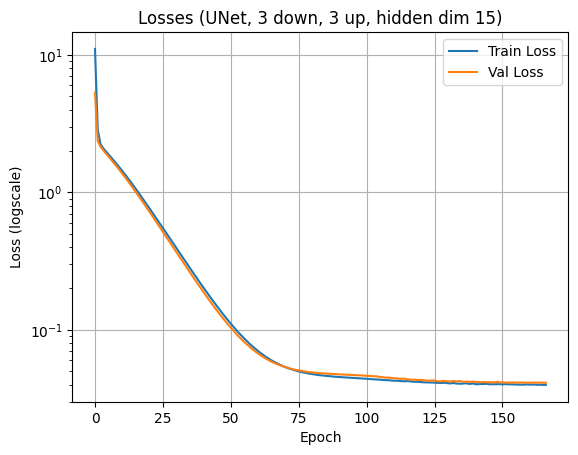

In [142]:
plot_loss(
    train_losses=train_losses,
    val_losses=val_losses,
    log=True,
    title="Losses (UNet, 3 down, 3 up, hidden dim 15)",
)

In [120]:
from MatrixVectorizer import MatrixVectorizer

from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import networkx as nx
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor


def evaluation_metrics(pred, true, print: bool = False, n_jobs=1):

    def compute_metrics(i):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred[i], edge_attr="weight")
        gt_graph = nx.from_numpy_array(true[i], edge_attr="weight")

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc = mean_absolute_error(pred_bc_values, gt_bc_values)
        mae_ec = mean_absolute_error(pred_ec_values, gt_ec_values)
        mae_pc = mean_absolute_error(pred_pc_values, gt_pc_values)

        # Vectorize matrices
        pred_1d = MatrixVectorizer.vectorize(pred[i])
        gt_1d = MatrixVectorizer.vectorize(true[i])

        return mae_bc, mae_ec, mae_pc, pred_1d, gt_1d

    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    num_test_samples = len(pred)

    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        results = list(executor.map(compute_metrics, range(num_test_samples)))

    for result in results:
        mae_bc.append(result[0])
        mae_ec.append(result[1])
        mae_pc.append(result[2])
        pred_1d_list.append(result[3])
        gt_1d_list.append(result[4])

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    if print:
        print("MAE: ", mae)
        print("PCC: ", pcc)
        print("Jensen-Shannon Distance: ", js_dis)
        print("Average MAE betweenness centrality:", avg_mae_bc)
        print("Average MAE eigenvector centrality:", avg_mae_ec)
        print("Average MAE PageRank centrality:", avg_mae_pc)

    return {
        "mae": mae,
        "pcc": pcc,
        "js_dis": js_dis,
        "avg_mae_bc": avg_mae_bc,
        "avg_mae_ec": avg_mae_ec,
        "avg_mae_pc": avg_mae_pc,
    }


@torch.no_grad()
def evaluate_model(model, dataloader, X_val=None, n_jobs=1):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """

    model.eval()

    preds = []
    true = []
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    progress_bar.set_description("Evaluating...")
    for i, batch in progress_bar:
        inputs, targets = batch
        inputs = inputs.squeeze(0)
        targets = targets.squeeze(0)
        inputs.to(model.device)
        if X_val is not None:
            X = X_val[i]
        else:
            X = None
        outputs, _, _ = model(A=inputs, X=X)
        preds.append(outputs.detach().cpu().numpy())
        true.append(targets.detach().cpu().numpy())

    batch_metrics = evaluation_metrics(preds, true, n_jobs=n_jobs)
    # Convert to python float
    batch_metrics = {k: float(v) for k, v in batch_metrics.items()}

    return batch_metrics

In [133]:
## Evaluation metrics

# Evaluate the model on the validation set

eval_metrics = evaluate_model(
    model,
    data_module.val_dataloader(),
    X_val=val_node_features,
)

print(eval_metrics)

Evaluating...: 100%|██████████| 34/34 [00:00<00:00, 129.28it/s]


{'mae': 0.16439081728458405, 'pcc': 0.47462210059165955, 'js_dis': 0.3106870651245117, 'avg_mae_bc': 0.018905860180731697, 'avg_mae_ec': 0.013103879869223584, 'avg_mae_pc': 0.0005575910534142903}


In [134]:
import json

with open("outputs/unet/eval_metrics-27-02.json", "w") as f:
    json.dump({k: float(v) for k, v in eval_metrics.items()}, f)

In [62]:
from MatrixVectorizer import MatrixVectorizer
import pandas as pd


@torch.no_grad()
def predict(model, dataloader, X_test=None):
    model.eval()

    preds = []
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    progress_bar.set_description("Predicting...")
    for i, batch in progress_bar:

        inputs = batch.squeeze(0)
        inputs.to(model.device)
        X = X_test[i] if X_test is not None else None
        outputs, _, _ = model(inputs, X=X)
        preds.append(outputs.detach().cpu().numpy())

    # Vectorize matrices
    preds = [MatrixVectorizer.vectorize(p) for p in preds]
    preds = np.array(preds)

    # Submission format
    print(preds.shape)
    submission_df = pd.DataFrame(
        {"ID": range(1, len(preds.flatten()) + 1), "Predicted": preds.flatten()}
    )
    submission_df.to_csv("outputs/unet/submission.csv", index=False)

In [143]:
import importlib
import slim

importlib.reload(slim)


predict(model, test_dataloader, X_test=X_val)

Predicting...: 100%|██████████| 112/112 [00:00<00:00, 167.52it/s]


(112, 35778)


In [144]:
df = pd.read_csv("outputs/unet/submission.csv")
df

,ID,Predicted
0,1,0.428091
1,2,0.548489
2,3,0.511098
3,4,0.312395
4,5,0.287518
...,...,...
4007131,4007132,0.151048
4007132,4007133,0.075221
4007133,4007134,0.141444
4007134,4007135,0.055945


In [145]:
!kaggle competitions submit -c dgl-2025-brain-graph-super-resolution-challenge -f outputs/unet/submission.csv -m "UNet"

100%|██████████████████████████████████████| 70.7M/70.7M [00:02<00:00, 27.8MB/s]
Successfully submitted to DGL 2025: Brain Graph Super-Resolution Challenge

In [132]:
# Save the model
torch.save(model.state_dict(), "outputs/unet/unet-27-02.pth")